In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Parameters

In [2]:
dataset='ElectricDevices'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='feat',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [4]:
print(test_y.shape)

(7711,)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../ClassificationModels/models/{dataset}/ResNet'))
model.eval()
#fit(model,train_loader,test_loader)
#if dataset in os.listdir('../ClassificationModels/models/'):
#    print('Folder exists')
#else: 
#    os.mkdir(f'../ClassificationModels/models/{dataset}')
#torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/ResNet')

#test_preds, ground_truth = get_all_preds(model, test_loader)
#ground_truth=np.argmax(ground_truth,axis=1)

#sns.set(rc={'figure.figsize':(5,4)})
#heatmap=confusion_matrix(ground_truth, test_preds)
#sns.heatmap(heatmap, annot=True)
#plt.savefig(f'../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
#plt.close()
#acc= accuracy_score(ground_truth, test_preds)
#a = classification_report(ground_truth, test_preds, output_dict=True)
#dataframe = pd.DataFrame.from_dict(a)
#dataframe.to_csv(f'../ClassificationModels/models/{dataset}/classification_report.csv', index = False)

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

# Explanation Algo

In [7]:
item=test_x[10].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [8]:
print(y_target)

[[3.2852639e-24 3.9285800e-13 3.3342823e-28 8.9749534e-05 9.9946076e-01
  4.3696380e-04 1.2602746e-05]]


In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import NativeGuideCF
exp_model=NativeGuideCF(model,shape,(train_x,train_y), backend='PYT', mode='feat')

2022-06-14 08:52:46.668850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 08:52:46.668872: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
exp,label=exp_model.explain(item, np.argmax(y_target,axis=1),method='dtw_bary_center')

In [11]:
label=0

In [12]:
print(exp)

[[[-0.21350851 -0.19395238 -0.19395238 -0.19395238 -0.19395238
   -0.19395238 -0.19395238 -0.19395238 -0.19395238 -0.19395238
   -0.19395238  0.51028881  5.65712164  5.65712164 -0.46616886
   -0.45151731  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.03740601  0.03740601
    0.03740601  0.03740601  0.03740601  0.6225969  -0.19395238
   -0.19395238 -0.19395238 -0.21162294 -0.19395238 -0.19395238
   -0.19395238 -0.19395238 -0.19395238 -0.19395238 -0.19395238
   -0.19395238 -0.19395238 -0.19395238 -0.19395238 -0.19395238
   -0.19395238 -0.19395238 -0.19395238 -0.19395238 -0.19395238
   -0.19395238 -0.19395238 -0.19395238 -0.19395238 -0.1

In [13]:
print(exp.shape)

(1, 1, 96)


# Plot Item 

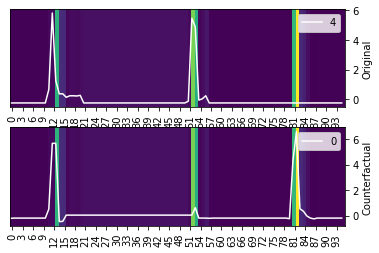

In [14]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

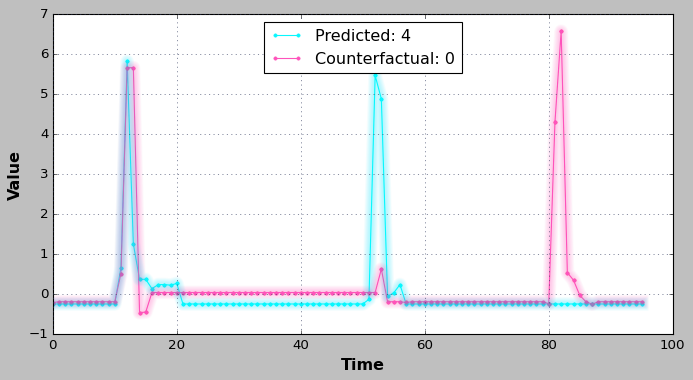

In [15]:
exp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)